In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [14]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

from PIL import Image
import cv2

In [15]:
metadata_path = os.path.join('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
metadata = pd.read_csv(metadata_path)
metadata.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [16]:
metadata.shape

(10015, 7)

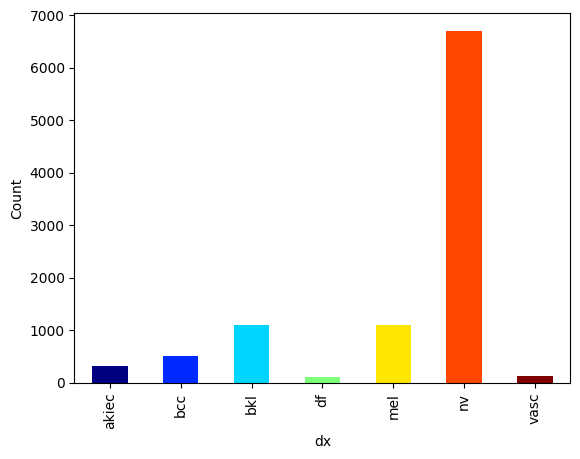

In [17]:
count = metadata.dx.value_counts().sort_index()

unique_vals = count.index
colors = plt.cm.jet(np.linspace(0, 1, len(unique_vals)))

count.plot(kind='bar', color=colors)

plt.ylabel('Count')
plt.show()

In [18]:
def check_for_missing_data(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    return summary

check_for_missing_data(metadata)

Name   dtypes  Missing
0     lesion_id   object        0
1      image_id   object        0
2            dx   object        0
3       dx_type   object        0
4           age  float64       57
5           sex   object        0
6  localization   object        0

In [19]:
metadata.fillna({'age': metadata['age'].mean()}, inplace=True)

In [20]:
def convert_float_to_int(df, column_name):
    if df[column_name].dtype == 'float64':
        df[column_name] = df[column_name].astype(int)
    return df

metadata = convert_float_to_int(metadata,'age')
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   lesion_id     10015 non-null  object
 1   image_id      10015 non-null  object
 2   dx            10015 non-null  object
 3   dx_type       10015 non-null  object
 4   age           10015 non-null  int64 
 5   sex           10015 non-null  object
 6   localization  10015 non-null  object
dtypes: int64(1), object(6)
memory usage: 547.8+ KB


In [21]:
def check_for_duplicate_rows(df):
    size = df.shape
    sum_duplicates = df.duplicated().sum()
    sum_null = df.isnull().sum()
    return print("Number of Samples:" ,size[0],"\nDuplicated Entries: " ,sum_duplicates,"\nNull Entries:","\n",sum_null)

check_for_duplicate_rows(metadata)

Number of Samples: 10015 
Duplicated Entries:  0 
Null Entries: 
 lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64


In [22]:
lesion_id_cnt = metadata['lesion_id'].value_counts()
def check_duplicates_lesions(id):
    if lesion_id_cnt[id] > 1:
        return True
    else:
        return False

metadata['dup_les'] = metadata['lesion_id'].map(check_duplicates_lesions)

metadata['dup_les'].value_counts()

dup_les
False    5514
True     4501
Name: count, dtype: int64

In [23]:
metadata = metadata[metadata.dup_les == False]
metadata.shape

(5514, 8)

### Load the image paths

Create 2 paths from input. The images are separated in these paths, so if they do not exist in path 1 they probably exist in path 2. Scanning all the rows using the "dx" and the "image_id" columns we can add the image path in a separete column in the dataframe.

In [24]:
base1_path = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
base2_path = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'

image_paths = []

for index, row in metadata.iterrows():
    image_id = row['image_id']

    image_path_1 = os.path.join(base1_path, f'{image_id}.jpg')
    image_path_2 = os.path.join(base2_path, f'{image_id}.jpg')

    if os.path.exists(image_path_1):
        image_paths.append(image_path_1)
    elif os.path.exists(image_path_2):
        image_paths.append(image_path_2)
    else:
        print(f'Image {image_id} not found in either path.')

# Add the image paths to your DataFrame
metadata['image_path'] = image_paths

metadata.head()

lesion_id      image_id   dx dx_type  age     sex localization  dup_les  \
10  HAM_0001396  ISIC_0025276  bkl   histo   55  female        trunk    False   
15  HAM_0007207  ISIC_0031326  bkl   histo   65    male         back    False   
20  HAM_0006071  ISIC_0032343  bkl   histo   70  female         face    False   
33  HAM_0005612  ISIC_0024981  bkl   histo   80    male        scalp    False   
34  HAM_0005388  ISIC_0027815  bkl   histo   80    male        chest    False   

                                           image_path  
10  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  
15  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  
20  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  
33  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  
34  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...

In [25]:
metadata.shape

(5514, 9)

### Exploration

<Axes: ylabel='count'>

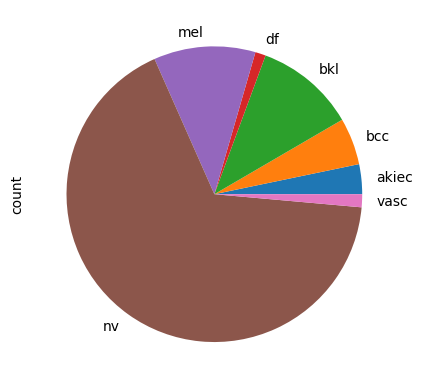

In [26]:
count.plot(kind='pie')

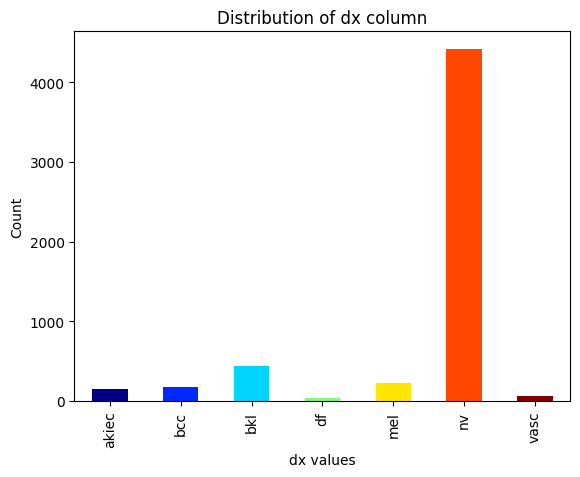

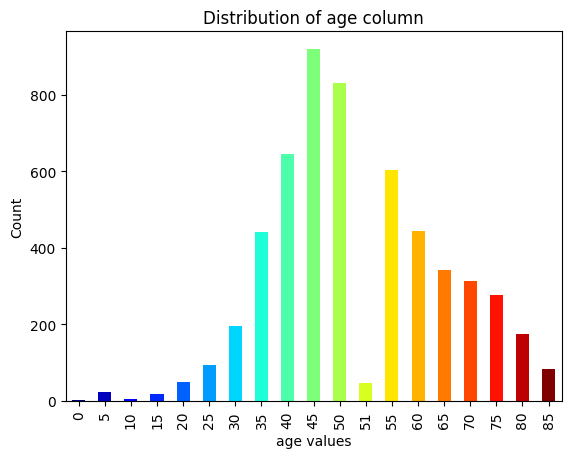

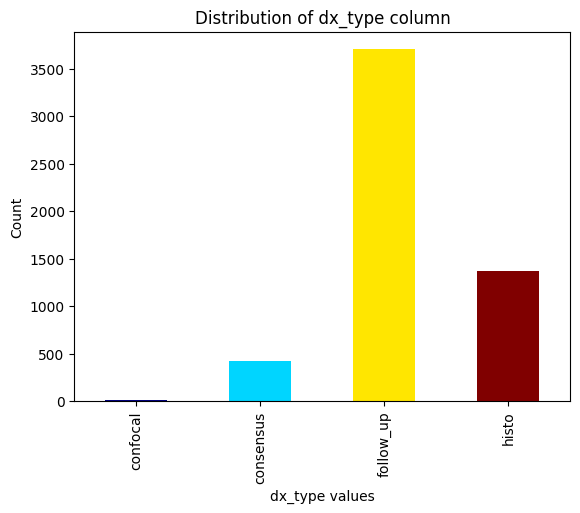

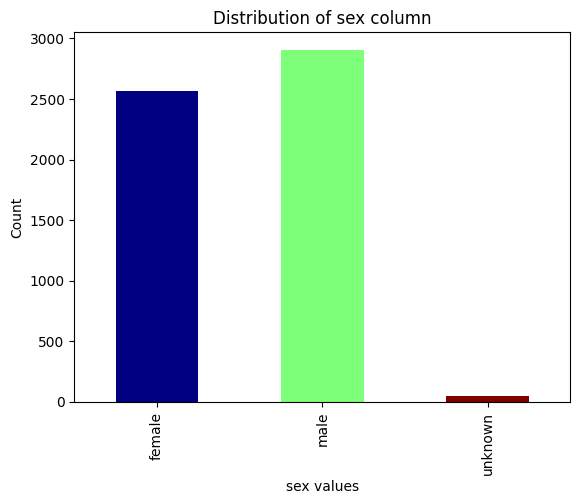

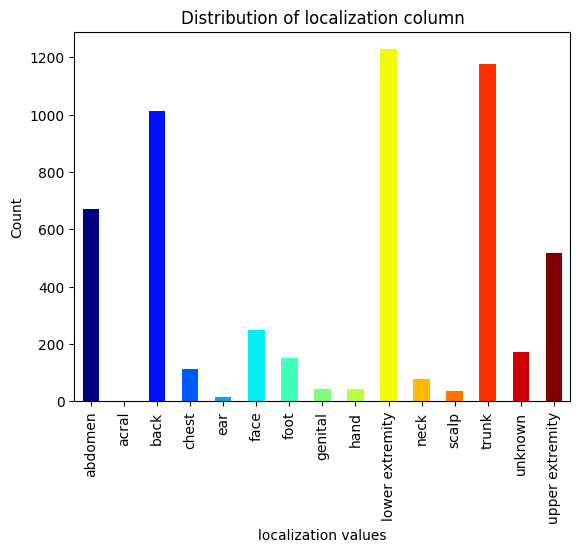

In [27]:
columns_exp = ['dx','age','dx_type', 'sex', 'localization']

for column in columns_exp:
  count = metadata[column].value_counts().sort_index()

  unique_vals = count.index
  colors = plt.cm.jet(np.linspace(0, 1, len(unique_vals)))

  count.plot(kind='bar', color=colors)

  plt.xlabel(f'{column} values')
  plt.ylabel('Count')
  plt.title(f'Distribution of {column} column')
  plt.show()

In [28]:
metadata.loc[metadata['sex']=='unknown'].shape

(45, 9)

In [29]:
metadata.loc[metadata['localization']=='unknown'].shape

(173, 9)

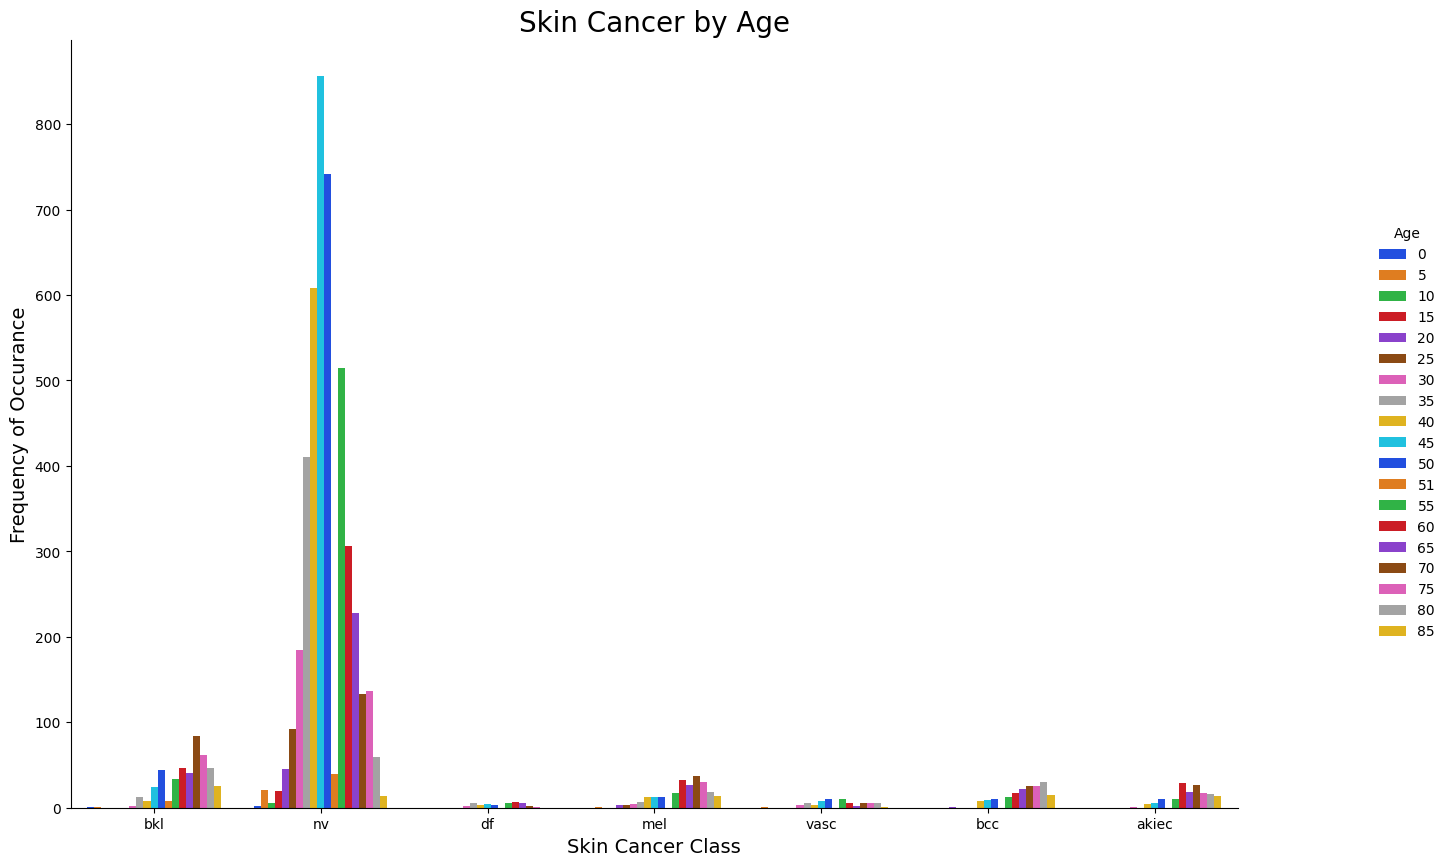

In [30]:
#Skin Cancer by age
g = sns.catplot(x="dx", kind="count", hue="age", palette='bright', data=metadata)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer by Age', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Age')

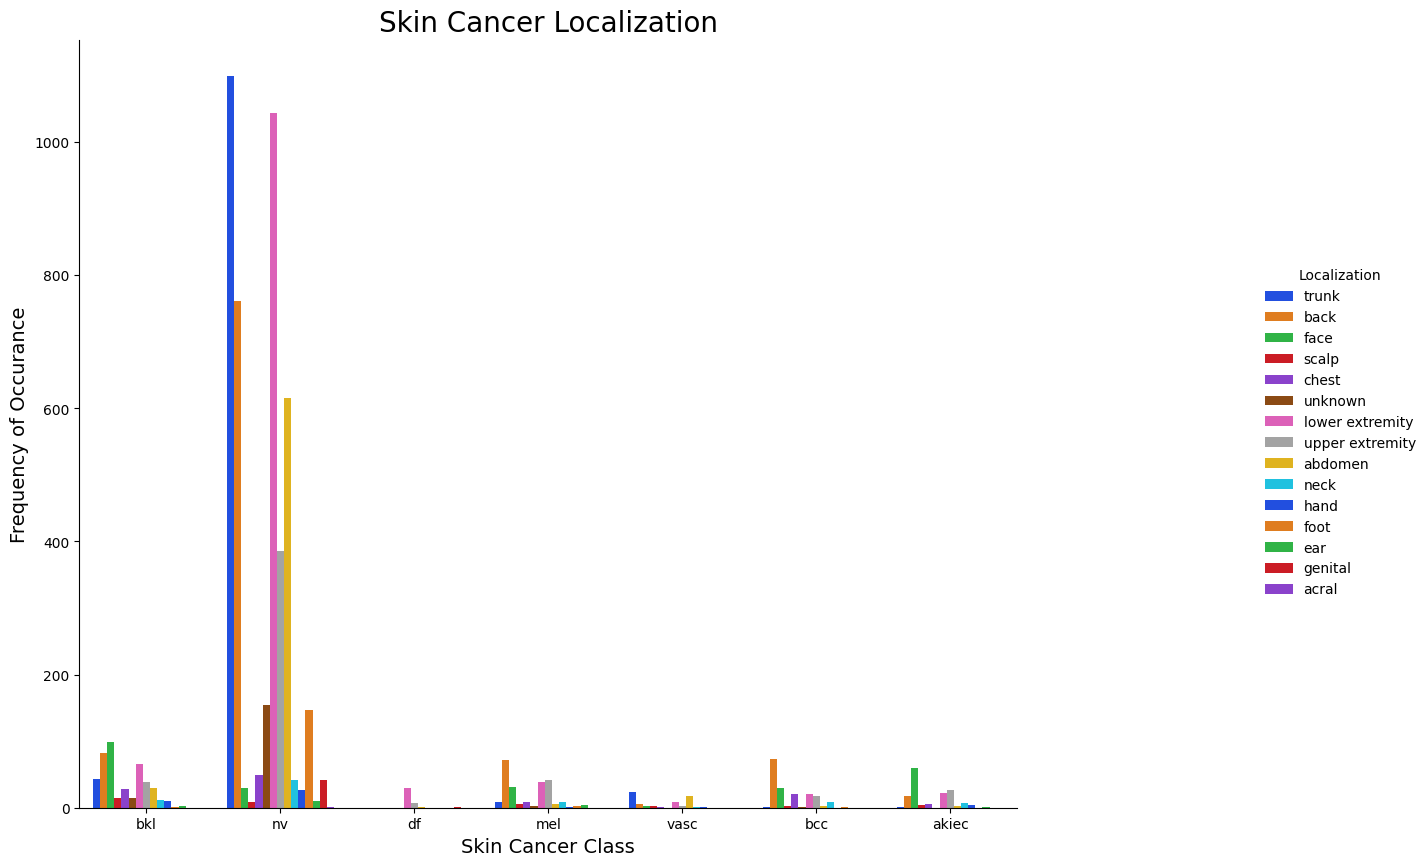

In [31]:
g = sns.catplot(x="dx", kind="count", hue="localization", palette='bright', data=metadata)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer Localization', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Localization')

In [32]:
metadata.head()

lesion_id      image_id   dx dx_type  age     sex localization  dup_les  \
10  HAM_0001396  ISIC_0025276  bkl   histo   55  female        trunk    False   
15  HAM_0007207  ISIC_0031326  bkl   histo   65    male         back    False   
20  HAM_0006071  ISIC_0032343  bkl   histo   70  female         face    False   
33  HAM_0005612  ISIC_0024981  bkl   histo   80    male        scalp    False   
34  HAM_0005388  ISIC_0027815  bkl   histo   80    male        chest    False   

                                           image_path  
10  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  
15  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  
20  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  
33  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  
34  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...

### Plot images from each class and their color distributions

In [33]:
def pltImg(images, labels, row_num, col_num):
    fig, axes = plt.subplots(row_num, col_num, figsize=(15, 8))
    axes = axes.ravel()  # Flatten axes array

    for i, image in enumerate(images):
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"Class: {labels[i]}\nMean intensity: {np.mean(image):.1f}")

    plt.tight_layout()
    plt.show()


def pltHist(images, labels, row_num, col_num):
    fig, axes = plt.subplots(row_num, col_num, figsize=(15, 8))
    axes = axes.ravel()  # Flatten axes array
    colors = ["red", "green", "blue"]

    for i, image in enumerate(images):
        image_array = np.array(image)

        # Plotting all channels with colors
        for channel in range(3):
            hist, bin_edges = np.histogram(image_array[:, :, channel], bins=256, range=(0, 256))
            axes[i].plot(bin_edges[:-1], hist, color=colors[channel])

        axes[i].set_title(f"Class: {labels[i]}")

    plt.tight_layout()
    plt.show()

In [34]:
def randImg(df, label, seed, sample_size):
    # Filter dataframe for specific label/class
    df_class = df[df['dx'] == label]

    # Randomly sample images from this class
    random.seed(seed)
    sample_df = df_class.sample(n=sample_size)

    images = []
    labels = []
    for index, row in sample_df.iterrows():
        image_path = row['image_path']
        if os.path.exists(image_path):
            image = Image.open(image_path)
            images.append(image)
            labels.append(label)
        else:
            print(f"Image not found: {image_path}")

    return images, labels


--- Showcasing examples for class: bkl ---



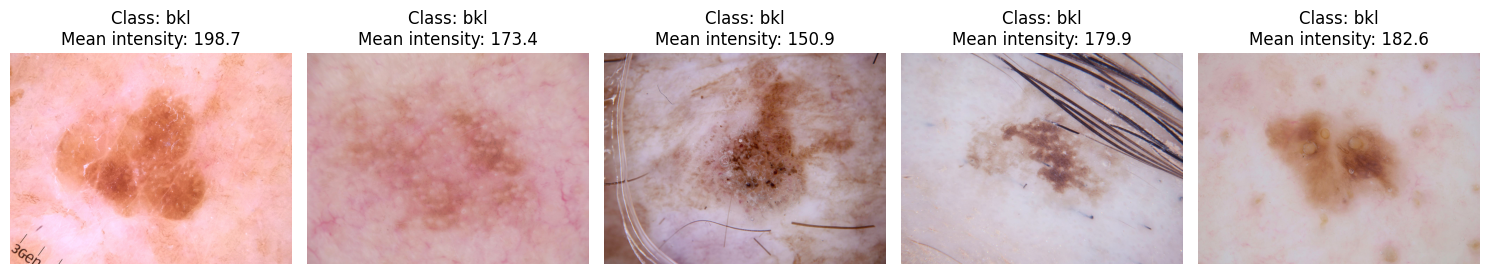

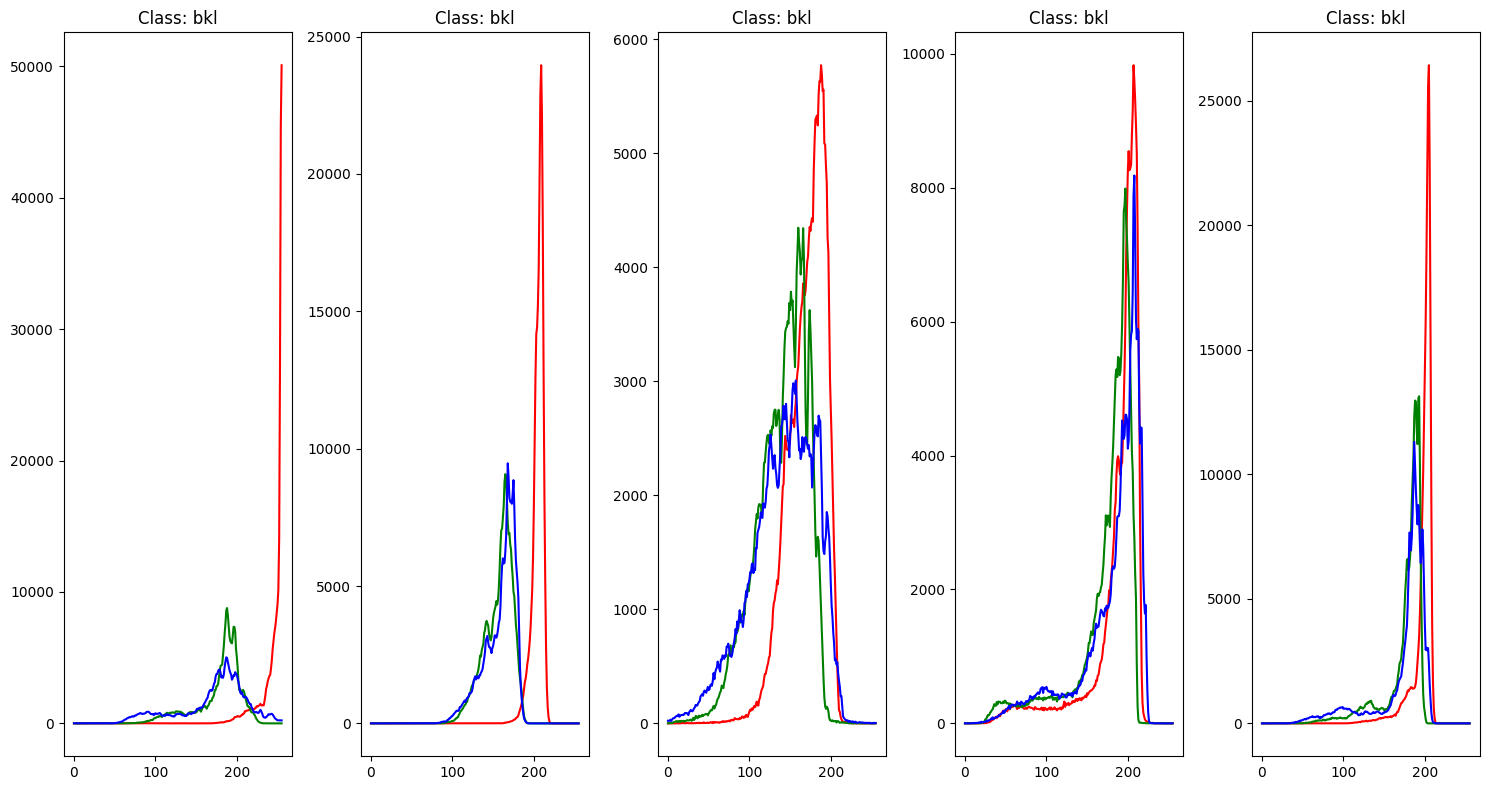


--- Showcasing examples for class: nv ---



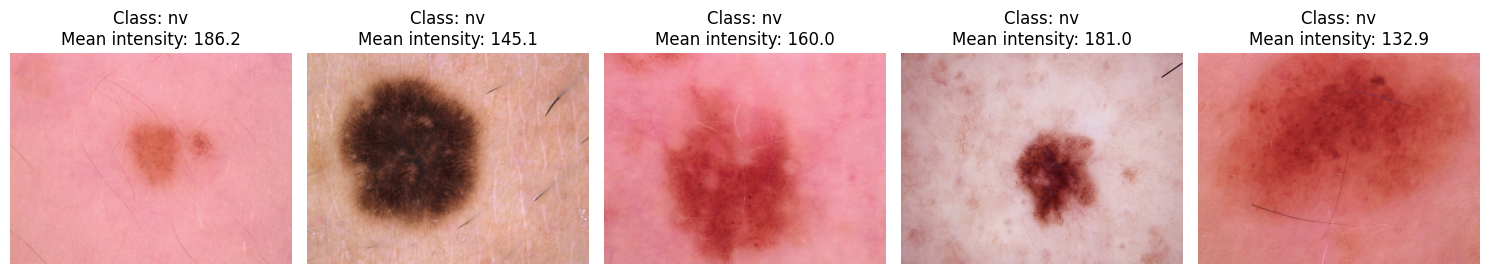

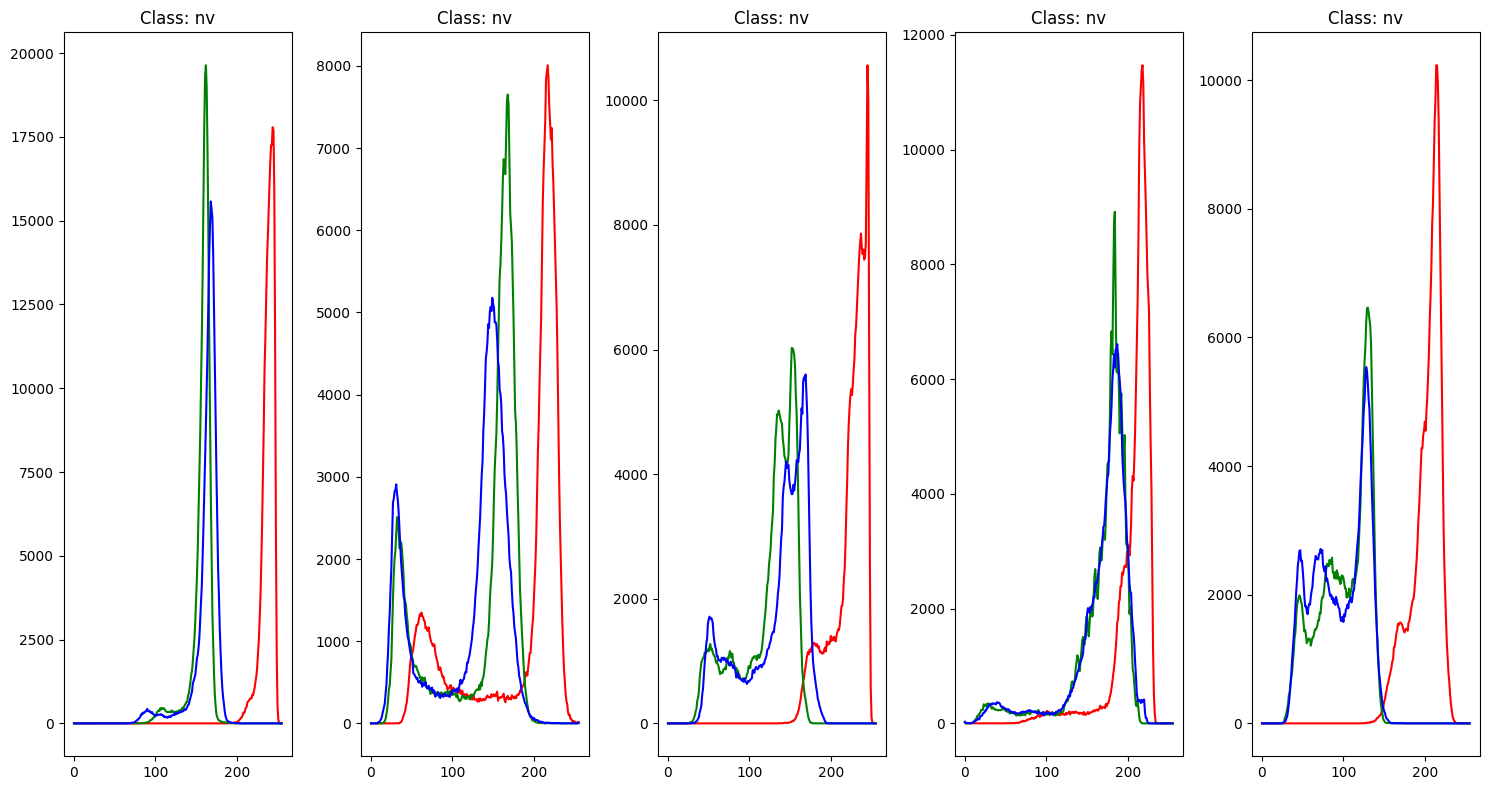


--- Showcasing examples for class: df ---



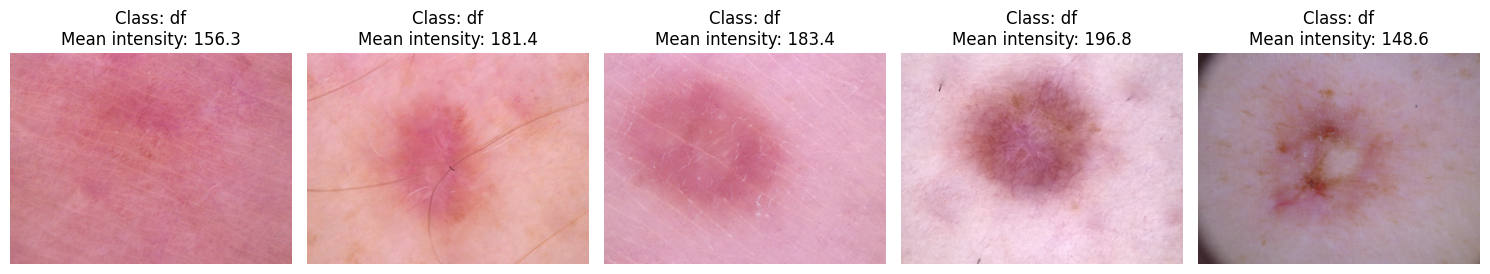

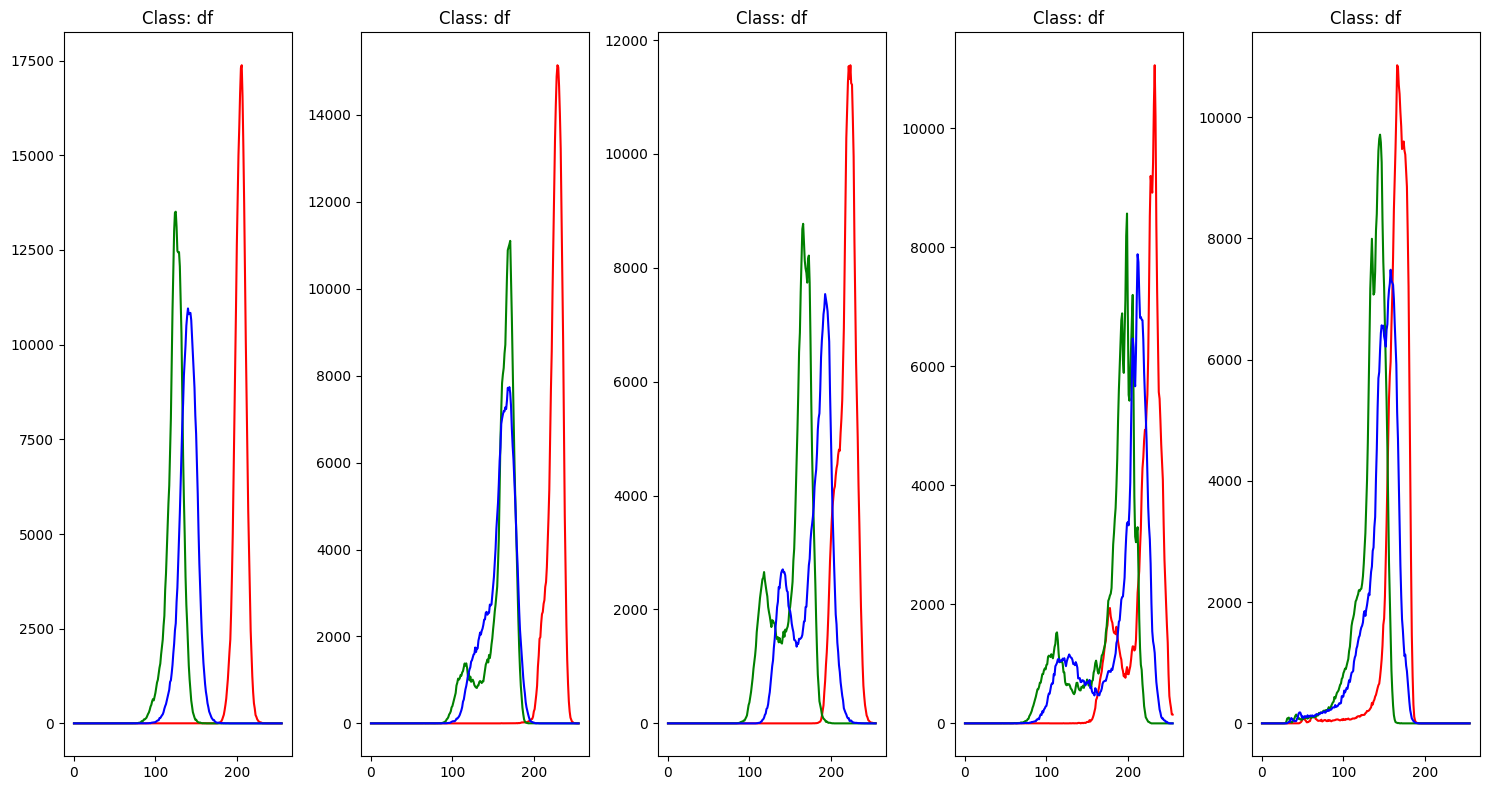


--- Showcasing examples for class: mel ---



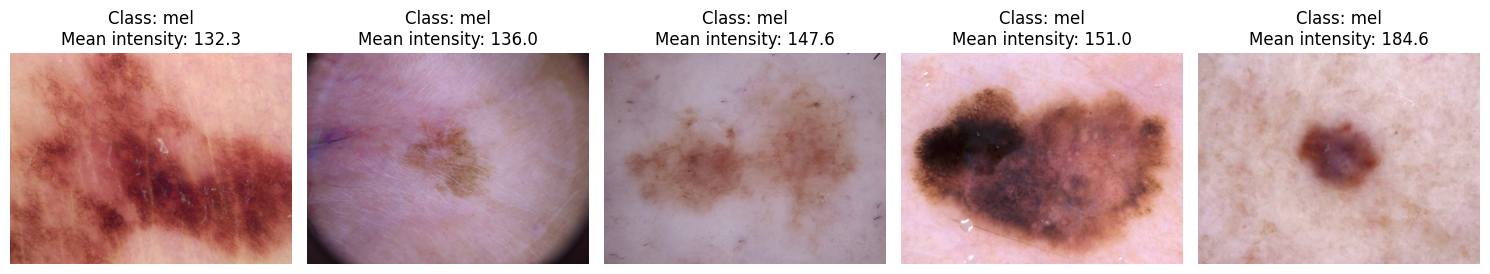

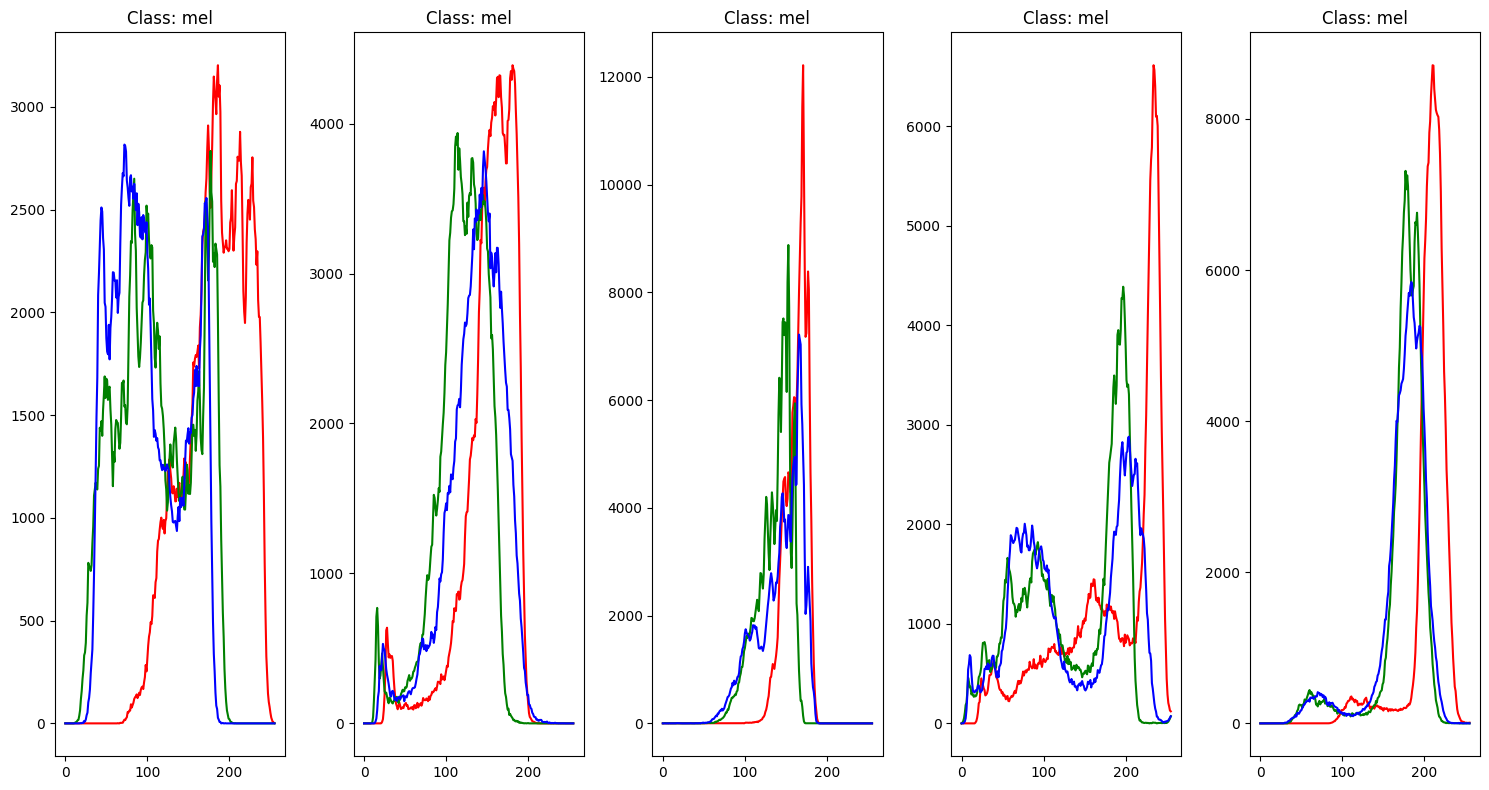


--- Showcasing examples for class: vasc ---



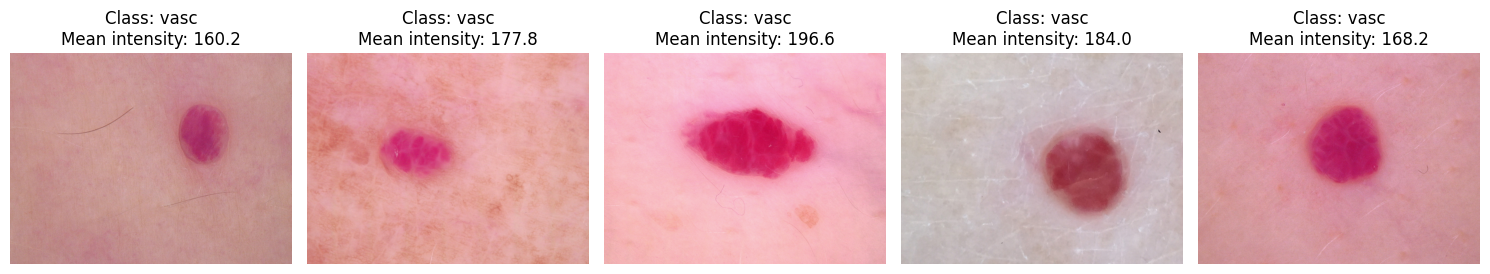

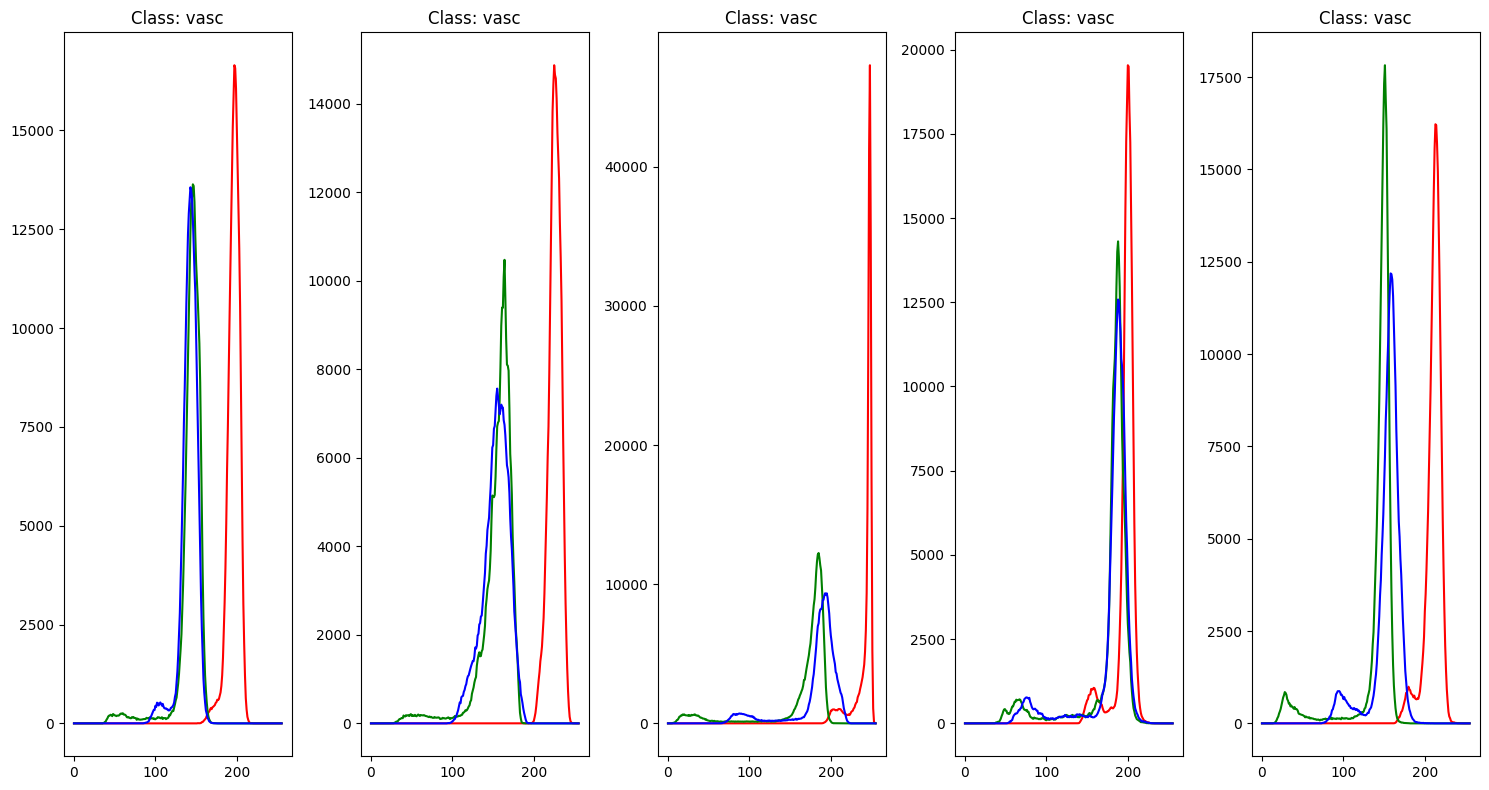


--- Showcasing examples for class: bcc ---



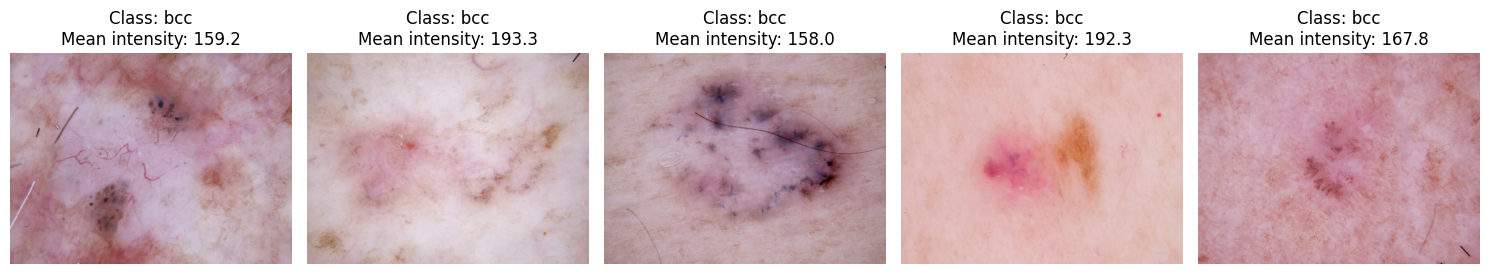

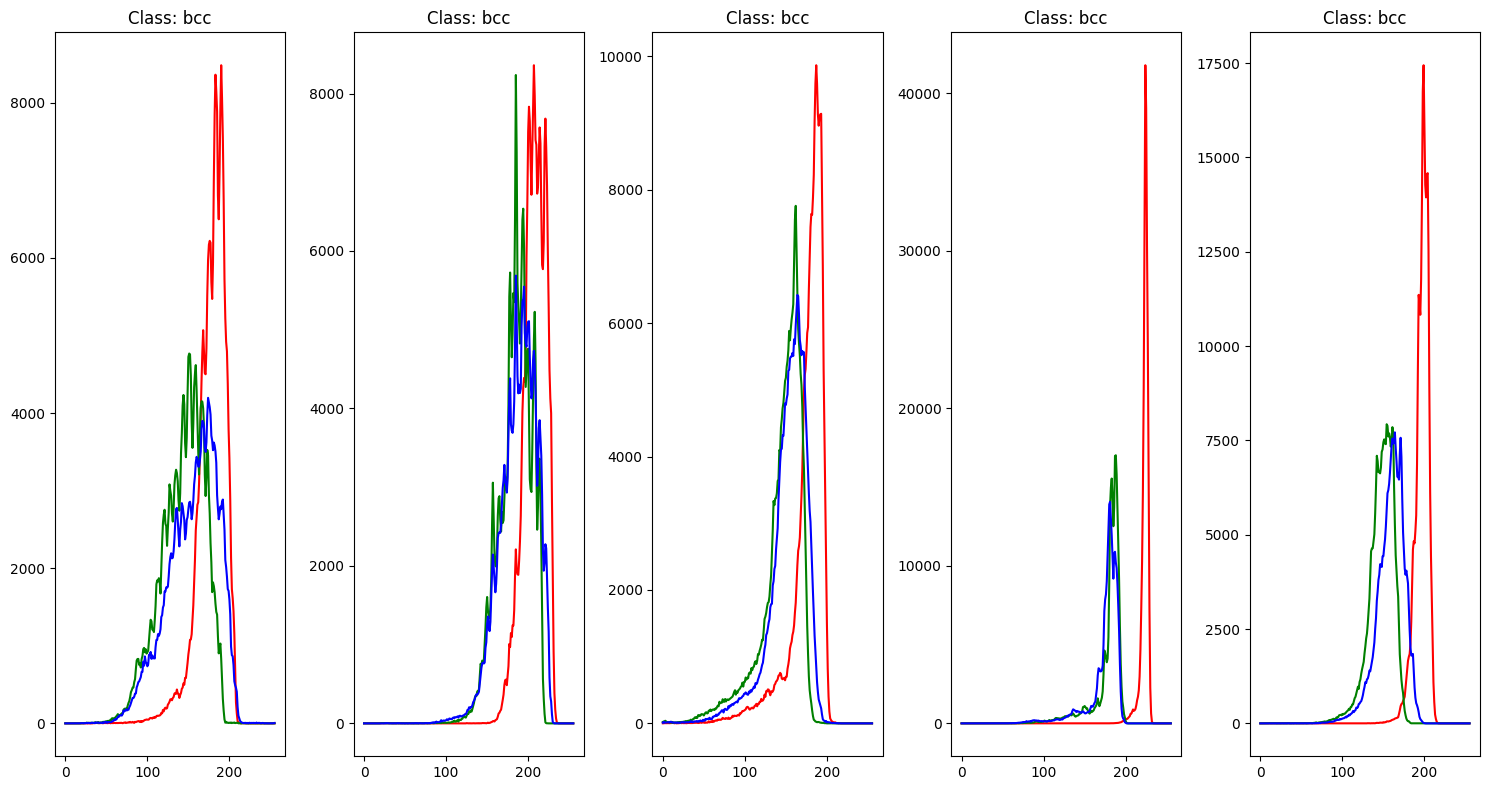


--- Showcasing examples for class: akiec ---



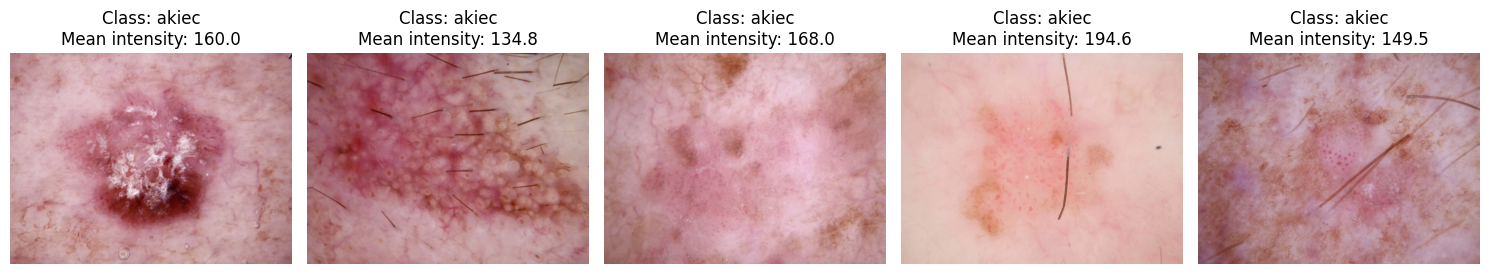

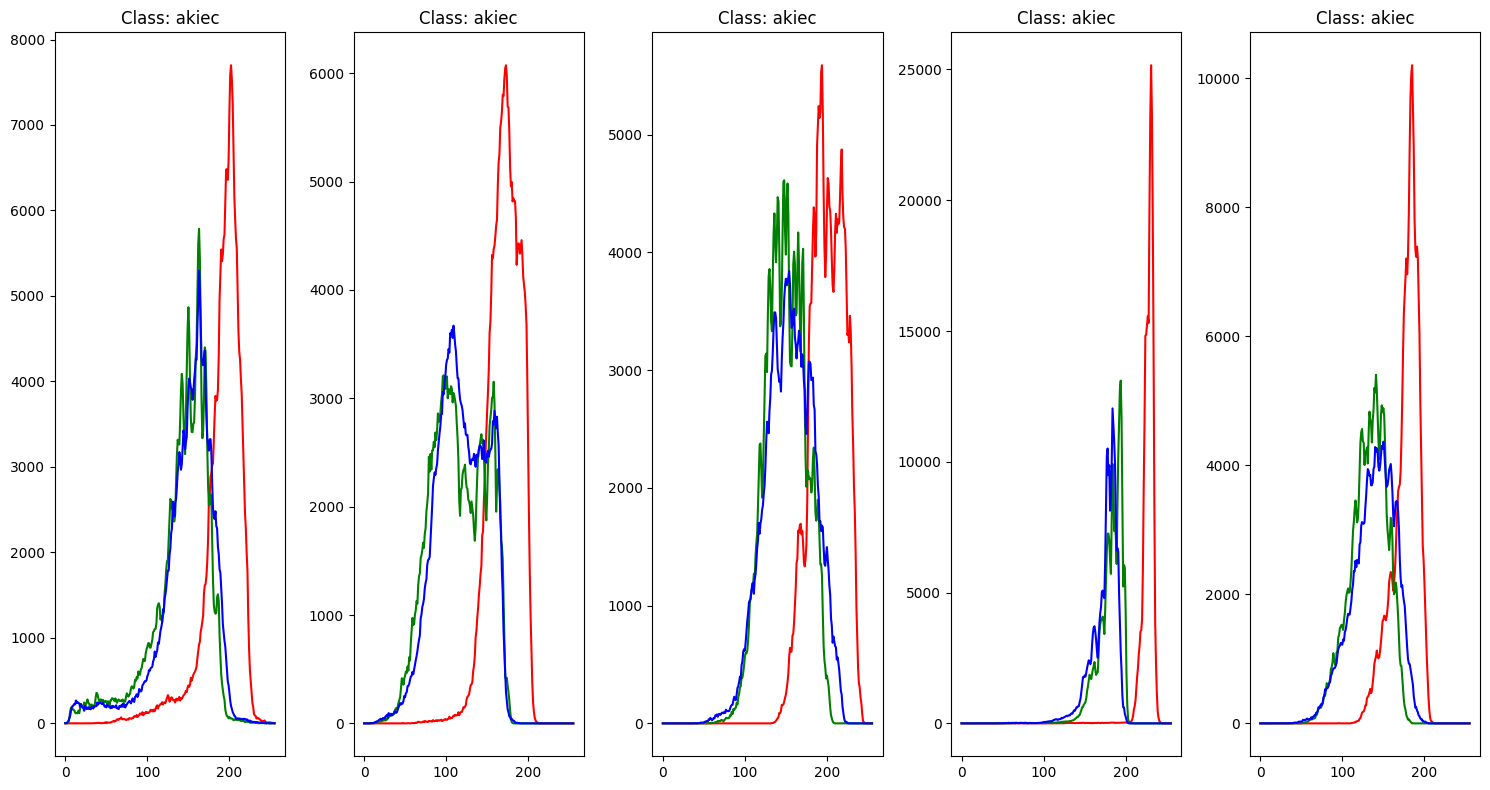

In [35]:
class_labels = ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']

for class_label in class_labels:
    print(f"\n--- Showcasing examples for class: {class_label} ---\n")
    images, labels = randImg(df=metadata, label=class_label, seed=42, sample_size=5)

    # For displaying images
    pltImg(images, labels, 1, 5)
    # pltImgEq(images, labels, 1, 5)
    # For displaying histograms
    pltHist(images, labels, 1, 5)

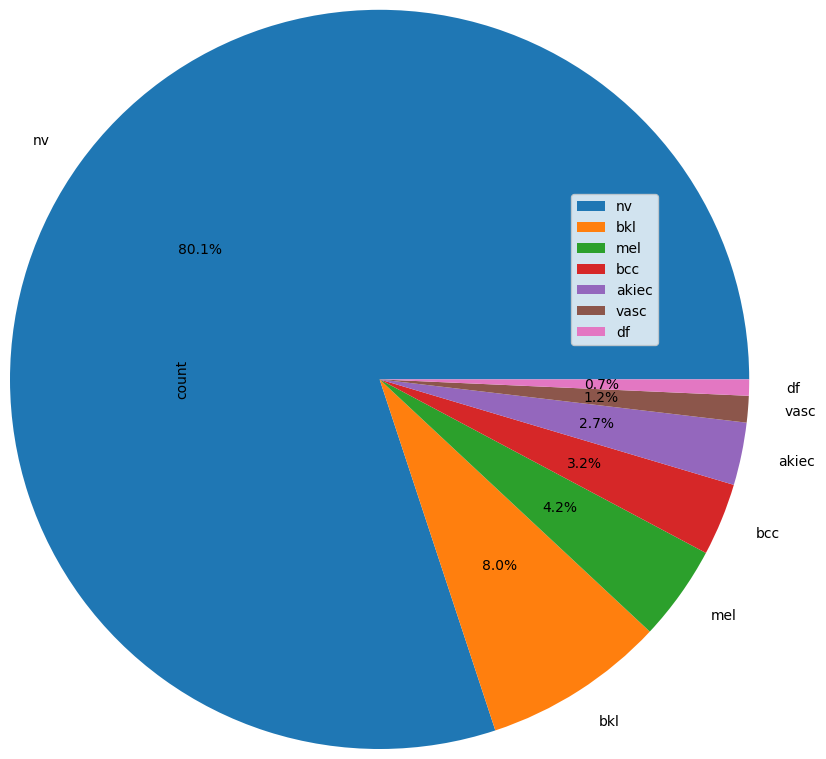

In [36]:
count = metadata['dx'].value_counts()
ax = count.plot(kind="pie", autopct='%1.1f%%', legend=True,radius=2.5)
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

In [37]:
count

dx
nv       4415
bkl       440
mel       230
bcc       175
akiec     151
vasc       64
df         39
Name: count, dtype: int64

LABELS :

Melanocytic nevi (nv) -
Melanocytic nevi are benign neoplasms of melanocytes and appear in a myriad of variants, which all are included in our series. The variants may differ significantly from a dermatoscopic point of view.

[4415 images]

Melanoma (mel) -
Melanoma is a malignant neoplasm derived from melanocytes that may appear in different variants. If excised in an early stage it can be cured by simple surgical excision. Melanomas can be invasive or non-invasive (in situ). We included all variants of melanoma including melanoma in situ, but did exclude non-pigmented, subungual, ocular or mucosal melanoma.

[230 images]

Benign keratosis-like lesions (bkl) -
"Benign keratosis" is a generic class that includes seborrheic ker- atoses ("senile wart"), solar lentigo - which can be regarded a flat variant of seborrheic keratosis - and lichen-planus like keratoses (LPLK), which corresponds to a seborrheic keratosis or a solar lentigo with inflammation and regression [22]. The three subgroups may look different dermatoscop- ically, but we grouped them together because they are similar biologically and often reported under the same generic term histopathologically. From a dermatoscopic view, lichen planus-like keratoses are especially challeng- ing because they can show morphologic features mimicking melanoma [23] and are often biopsied or excised for diagnostic reasons.

[440 images]

Basal cell carcinoma (bcc) -
Basal cell carcinoma is a common variant of epithelial skin cancer that rarely metastasizes but grows destructively if untreated. It appears in different morphologic variants (flat, nodular, pigmented, cystic, etc) [21], which are all included in this set.

[175 images]

Actinic keratoses (akiec) -
Actinic Keratoses (Solar Keratoses) and intraepithelial Carcinoma (Bowen’s disease) are common non-invasive, variants of squamous cell car- cinoma that can be treated locally without surgery. Some authors regard them as precursors of squamous cell carcinomas and not as actual carci- nomas. There is, however, agreement that these lesions may progress to invasive squamous cell carcinoma - which is usually not pigmented. Both neoplasms commonly show surface scaling and commonly are devoid of pigment. Actinic keratoses are more common on the face and Bowen’s disease is more common on other body sites. Because both types are in- duced by UV-light the surrounding skin is usually typified by severe sun damaged except in cases of Bowen’s disease that are caused by human papilloma virus infection and not by UV. Pigmented variants exists for Bowen’s disease [19] and for actinic keratoses [20]. Both are included in this set.

[151 images]

Vascular lesions (vasc) -
Vascular skin lesions in the dataset range from cherry angiomas to angiokeratomas [25] and pyogenic granulomas [26]. Hemorrhage is also included in this category.

[64 images]

Dermatofibrom (df) -
Dermatofibroma is a benign skin lesion regarded as either a benign proliferation or an inflammatory reaction to minimal trauma. It is brown often showing a central zone of fibrosis dermatoscopically [24].

[39 images]

[Total images = 5514]

### Data Augmentation

In [38]:
metadata.dx.unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [39]:
count = metadata['dx'].value_counts().sort_index()
count

dx
akiec     151
bcc       175
bkl       440
df         39
mel       230
nv       4415
vasc       64
Name: count, dtype: int64

<Axes: ylabel='count'>

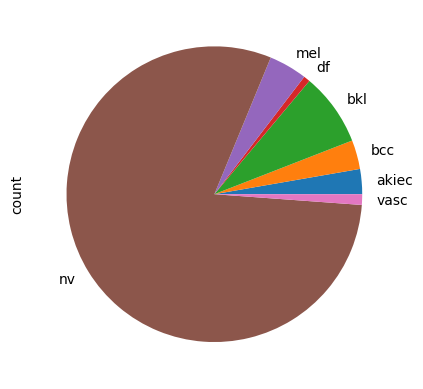

In [40]:
count.plot(kind='pie')

From this pie plot, we can see the huge imbalance between classes

In [41]:
def data_aug(df, col_name, val_name, class_max):
  ''' This function balances the classes by 2 using the overrepresentation of the minor class'''
  given_cols = df[df[col_name].isin([val_name, class_max])]
  class_counts = df[col_name].value_counts()
  class_count_max = class_counts[class_max]
  class_count_val = class_counts[val_name]
  max_class = given_cols[given_cols[col_name]==class_max]
  val_class = given_cols[given_cols[col_name]==val_name]
  val_class_over = val_class.sample(class_count_max,replace= True)
  df = df[df[col_name] != val_name]
  df = pd.concat([df,val_class_over],axis=0)
  return df

In [42]:
class_max = count.idxmax()

for val_name in metadata.dx.unique():
  if val_name != class_max:
    metadata = data_aug(metadata,'dx',val_name,class_max)

metadata.shape

(30905, 9)

<Axes: ylabel='count'>

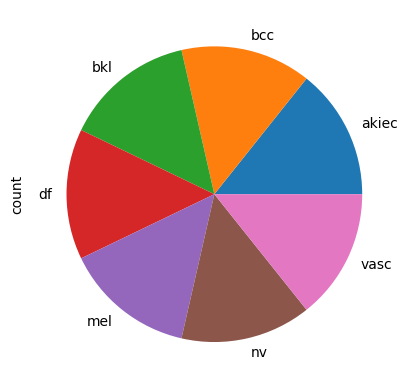

In [43]:
count = metadata['dx'].value_counts().sort_index()
count.plot(kind='pie')

### Data Export

For metadata['dx']:

'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'vasc': 4, 'bcc': 5, 'akiec': 6

In [44]:
enum_labels = {'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'vasc': 4, 'bcc': 5, 'akiec': 6}

metadata['dx_cat'] = metadata['dx'].map(enum_labels)

In [45]:
metadata.dx_cat.unique()

array([1, 0, 2, 3, 4, 5, 6])

In [46]:
metadata.to_csv('/kaggle/working/data_enum.csv', index=False)

The new file data_enum.csv it was created and saved in Output (working) directory. This directory is writable and is the default working directory in a Kaggle notebook.

__________

In [47]:
!pip install torchsummary
!pip install Dataloaders

In [48]:
from tqdm import tqdm

from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import models,transforms

#from Dataloaders.HAM10000Dataset import HAM10000Dataset
#from functions import normalization, Model_functions

import time

import random
from PIL import Image
import cv2
import gc
import optuna
import logging

## HAM10000 Dataset

In [49]:
class HAM10000Dataset(Dataset):
    def __init__(self, data, label_column='dx_cat', img_col='image_path', transform=None):
        """
        Custom Dataset for loading HAM10000 images and labels.

        Args:
            data (pd.DataFrame): DataFrame containing image paths and labels.
            label_column (str): Name of the column containing labels.
            img_col (str): Name of the column containing image paths.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.data = data.reset_index(drop=True)
        self.label_column = label_column
        self.img_col = img_col
        self.transform = transform

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.data)

    def __getitem__(self, idx):
        """Generates one sample of data."""
        # Get image path
        image_path = self.data.at[idx, self.img_col]

        # Open image
        image = Image.open(image_path).convert('RGB')

        # Get label
        label = self.data.at[idx, self.label_column]
        label = torch.tensor(label, dtype=torch.long)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

## Model Functions

In [50]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    return avg_train_loss, train_accuracy

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_valid_loss = valid_loss / len(val_loader)
    valid_accuracy = 100 * correct / total
    return avg_valid_loss, valid_accuracy

def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    return test_accuracy

def train_and_validate_model(model, train_loader, val_loader, test_loader, criterion, patience, optimizer, device, epochs, model_filename, verbose=False):
    min_valid_loss = np.inf

    total_loss_train = []
    total_loss_val = []
    total_acc_train = []
    total_acc_val = []
    stopping_ct = 0

    for epoch in tqdm(range(epochs)):
        if stopping_ct < patience:            
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            valid_loss, valid_acc = validate_epoch(model, val_loader, criterion, device)

            total_loss_train.append(train_loss)
            total_loss_val.append(valid_loss)
            total_acc_train.append(train_acc)
            total_acc_val.append(valid_acc)
            if verbose:
                print(f'Epoch {epoch+1}')
                print(f'Training Loss: {train_loss} \nTraining Accuracy: {train_acc}%')
                print(f'Validation Loss: {valid_loss} \nValidation Accuracy: {valid_acc}%')
                print('=======================================================================')
        if min_valid_loss > valid_loss:
            print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \nSaving The Model')
            print('=======================================================================')
            min_valid_loss = valid_loss
            torch.save(model.state_dict(), model_filename)
            stopping_ct = 0
        else:
            stopping_ct += 1

    best_model_state = torch.load(model_filename)
    model.load_state_dict(best_model_state)
    return model,total_loss_train, total_loss_val, total_acc_train, total_acc_val


def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


def initialise_model(model_name, num_classes, feature_extract, use_pretrained=True):
    '''
    grad = if the pretrained weights be updated
    use_pretrained = use pre trained weights or start from scratch
    '''
    model = None
    
    if model_name == 'resnet_pret':
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'densenet_pret':
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    else:
        print("Invalid model name, choose between 'resnet_pret', 'densenet_pret'.")
        exit()
    return model_ft


def conf_report(model_fitted,loader, model_type):
    """
    Generate and display a confusion matrix and a classification report for the predictions made by a model.

    Parameters:
    - model_fitted: The trained model that will be used to make predictions. The model should be compatible
                    with the data provided by the loader and should have a `to` method for device management
                    and an `argmax` method for getting predictions.
    - loader: A data loader that provides batches of data. Each batch should be a tuple containing data
              and its corresponding labels. The loader should be iterable.
    - model_type: A string indicating the type of the model. This is used for labeling purposes
                  when saving the confusion matrix figure.

    The function does the following:
    - Iterates over the provided data loader to collect model predictions and true labels.
    - Computes a confusion matrix both in raw and normalized form.
    - Displays heatmaps for both raw and normalized confusion matrices.
    - Prints a classification report showing main classification metrics.

    Outputs:
    - A figure with two subplots: the left one showing the normalized confusion matrix and the right
      one showing the raw confusion matrix. The figure is saved as 'Confusion_Matrix_{model_type}.png'.
    - A printed classification report in the console.
    """
    y_pred = []
    y_true = []
    for data, target in loader:
        data, target = data.to('cpu'), target.to('cpu')
        model_cpu = model_fitted.to('cpu')
        output = model_cpu(data)
        y_pred.extend(output.argmax(dim=1).tolist())
        y_true.extend(target.tolist())
    
    classes = [ 'bkl','nv','df','mel','vasc','bcc','akiec']

    cf_matrix = confusion_matrix(y_true, y_pred)
    df_temp = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, np.newaxis], index=classes, columns=classes)

    plt.figure(figsize=(24, 10))  

    plt.subplot(1, 2, 1)  
    sns.heatmap(df_temp, annot=True, fmt=".3f", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')

    plt.subplot(1, 2, 2)  
    sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Raw Confusion Matrix')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')

    plt.savefig(f'Confusion_Matrix_{model_type}.png')
    plt.show()

    report = classification_report(y_true, y_pred, target_names=classes)
    print('-------------------------------------------------------')
    print("Classification Report:\n")
    print(report)
    print('-------------------------------------------------------')

_____

In [51]:
data = pd.read_csv('/kaggle/working/data_enum.csv')
data = data.sample(frac=1)
data.head()

lesion_id      image_id   dx    dx_type  age     sex  \
3357   HAM_0003907  ISIC_0027587   nv  follow_up   60    male   
222    HAM_0003673  ISIC_0030016   nv  follow_up   35    male   
17155  HAM_0004669  ISIC_0028543  mel      histo   55  female   
22692  HAM_0001759  ISIC_0032497  bcc      histo   70  female   
10864  HAM_0003348  ISIC_0031799   df  consensus   70    male   

          localization  dup_les  \
3357   upper extremity    False   
222    lower extremity    False   
17155  upper extremity    False   
22692  lower extremity    False   
10864  lower extremity    False   

                                              image_path  dx_cat  
3357   /kaggle/input/skin-cancer-mnist-ham10000/HAM10...       1  
222    /kaggle/input/skin-cancer-mnist-ham10000/HAM10...       1  
17155  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...       3  
22692  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...       5  
10864  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...       2

## Preprocessing

### Normalize function

In [52]:
img_h, img_w = 224, 224

norm_means = [0.77148203, 0.55764165, 0.58345652]
norm_std = [0.12655577, 0.14245141, 0.15189891]

### Data Augmentation and normalization

Resize the data as 224x224 because most pretrained models are implemented to work with these sizes

In [53]:
# define the transformation of the train images.
transform = transforms.Compose([transforms.Resize((img_h,img_w)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_means, norm_std)])
# define the transformation of the val and test images.
val_test_transform = transforms.Compose([transforms.Resize((img_h,img_w)), transforms.ToTensor(),
                                        transforms.Normalize(norm_means, norm_std)])

In [54]:
data.head()

lesion_id      image_id   dx    dx_type  age     sex  \
3357   HAM_0003907  ISIC_0027587   nv  follow_up   60    male   
222    HAM_0003673  ISIC_0030016   nv  follow_up   35    male   
17155  HAM_0004669  ISIC_0028543  mel      histo   55  female   
22692  HAM_0001759  ISIC_0032497  bcc      histo   70  female   
10864  HAM_0003348  ISIC_0031799   df  consensus   70    male   

          localization  dup_les  \
3357   upper extremity    False   
222    lower extremity    False   
17155  upper extremity    False   
22692  lower extremity    False   
10864  lower extremity    False   

                                              image_path  dx_cat  
3357   /kaggle/input/skin-cancer-mnist-ham10000/HAM10...       1  
222    /kaggle/input/skin-cancer-mnist-ham10000/HAM10...       1  
17155  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...       3  
22692  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...       5  
10864  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...       2

### Data Loading

In [55]:
train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_data, val_data = train_test_split(train_val_data, test_size=0.5, random_state=42)

train_dataset = HAM10000Dataset(train_data, transform=transform)
val_dataset = HAM10000Dataset(val_data, transform=transform)
test_dataset = HAM10000Dataset(test_data, transform=transform)

In [56]:
batch_size = 32
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

print('Data len Train:', len(train_dataset), 'Val:', len(val_dataset), 'Test:', len(test_dataset))

Data len Train: 12362 Val: 12362 Test: 6181


### Batch check

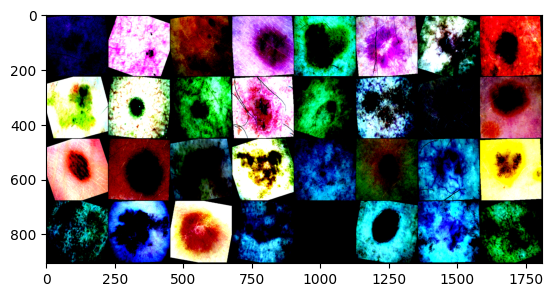

Labels:  tensor([4, 5, 0, 2, 3, 2, 6, 4, 6, 0, 5, 5, 1, 6, 4, 1, 1, 1, 5, 3, 5, 4, 5, 1,
        6, 3, 2, 5, 4, 0, 5, 6])


In [57]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('Labels: ', labels) 

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## Resnet

In [59]:
model_temp = 'resnet_pret'
feature_extract = False
num_classes = 7
model_res = initialise_model(model_temp, num_classes, feature_extract, use_pretrained=True)
model_res.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [60]:
input_size = (3, 224, 224)
print(summary(model_res, input_size, device=device.type))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [61]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_res.parameters(), lr=1e-3)

In [62]:
start_time = time.time()

In [63]:
epochs = 30
patience = 5
model_filename = 'resnet_pret.pth'
resnet_model, total_loss_train, total_loss_val, total_acc_train, total_acc_val = train_and_validate_model(
                        model_res, train_loader, val_loader,test_loader, criterion,patience, optimizer, device, epochs, model_filename,verbose=True)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1
Training Loss: 1.0664916561401476 
Training Accuracy: 61.09852774631936%
Validation Loss: 0.8694023271247706 
Validation Accuracy: 67.13314997573208%
Validation Loss Decreased(inf--->0.869402) 
Saving The Model


  3%|▎         | 1/30 [03:21<1:37:36, 201.95s/it]

Epoch 2
Training Loss: 0.7401937920917836 
Training Accuracy: 73.20821873483256%
Validation Loss: 0.7908723871837291 
Validation Accuracy: 69.60847759262255%
Validation Loss Decreased(0.869402--->0.790872) 
Saving The Model


  7%|▋         | 2/30 [06:42<1:33:50, 201.09s/it]

Epoch 3
Training Loss: 0.6179314392019611 
Training Accuracy: 78.05371299142534%
Validation Loss: 0.5788874912631604 
Validation Accuracy: 78.89500080893059%
Validation Loss Decreased(0.790872--->0.578887) 
Saving The Model


 10%|█         | 3/30 [10:03<1:30:27, 201.00s/it]

Epoch 4
Training Loss: 0.533952530771879 
Training Accuracy: 80.71509464487947%
Validation Loss: 0.4767577354760133 
Validation Accuracy: 82.93965377770587%
Validation Loss Decreased(0.578887--->0.476758) 
Saving The Model


 13%|█▎        | 4/30 [13:24<1:27:06, 201.01s/it]

Epoch 5
Training Loss: 0.45258040256432475 
Training Accuracy: 83.70004853583562%
Validation Loss: 0.46634136513838165 
Validation Accuracy: 82.55945639864099%
Validation Loss Decreased(0.476758--->0.466341) 
Saving The Model


 20%|██        | 6/30 [20:06<1:20:24, 201.01s/it]

Epoch 6
Training Loss: 0.4018943786082034 
Training Accuracy: 85.26128458178289%
Validation Loss: 0.7566723722666117 
Validation Accuracy: 73.03834331014399%
Epoch 7
Training Loss: 0.375773092534499 
Training Accuracy: 86.79825270991749%
Validation Loss: 0.3915482474736465 
Validation Accuracy: 86.69309173272933%
Validation Loss Decreased(0.466341--->0.391548) 
Saving The Model


 23%|██▎       | 7/30 [23:27<1:17:00, 200.91s/it]

Epoch 8
Training Loss: 0.3287016289640767 
Training Accuracy: 88.31904222617699%
Validation Loss: 0.3730263827267543 
Validation Accuracy: 86.82252062773014%
Validation Loss Decreased(0.391548--->0.373026) 
Saving The Model


 27%|██▋       | 8/30 [26:48<1:13:42, 201.03s/it]

Epoch 9
Training Loss: 0.28721008189888886 
Training Accuracy: 90.15531467400098%
Validation Loss: 0.30651410801928175 
Validation Accuracy: 89.33829477430837%
Validation Loss Decreased(0.373026--->0.306514) 
Saving The Model


 33%|███▎      | 10/30 [33:29<1:06:55, 200.78s/it]

Epoch 10
Training Loss: 0.26383869026520457 
Training Accuracy: 90.64876233619155%
Validation Loss: 0.32767555934860726 
Validation Accuracy: 88.82866850024269%
Epoch 11
Training Loss: 0.24226897468824105 
Training Accuracy: 91.65992557838537%
Validation Loss: 0.22599740794231726 
Validation Accuracy: 92.0158550396376%
Validation Loss Decreased(0.306514--->0.225997) 
Saving The Model


 37%|███▋      | 11/30 [36:51<1:03:42, 201.20s/it]

Epoch 12
Training Loss: 0.21848730755926565 
Training Accuracy: 92.15337324057596%
Validation Loss: 0.2162971948333643 
Validation Accuracy: 93.04319689370652%
Validation Loss Decreased(0.225997--->0.216297) 
Saving The Model


 43%|████▎     | 13/30 [43:32<56:53, 200.79s/it]  

Epoch 13
Training Loss: 0.1935071782269142 
Training Accuracy: 93.19689370651999%
Validation Loss: 0.3060462693142336 
Validation Accuracy: 89.2816696327455%
Epoch 14
Training Loss: 0.19382913628694162 
Training Accuracy: 93.08364342339428%
Validation Loss: 0.18159405564653472 
Validation Accuracy: 93.97346707652484%
Validation Loss Decreased(0.216297--->0.181594) 
Saving The Model


 47%|████▋     | 14/30 [46:52<53:28, 200.55s/it]

Epoch 15
Training Loss: 0.17869055651619223 
Training Accuracy: 93.81977026371138%
Validation Loss: 0.17139244215558128 
Validation Accuracy: 94.32939653777706%
Validation Loss Decreased(0.181594--->0.171392) 
Saving The Model


 50%|█████     | 15/30 [50:13<50:08, 200.59s/it]

Epoch 16
Training Loss: 0.1716453590832208 
Training Accuracy: 94.16761041902605%
Validation Loss: 0.16431981274853305 
Validation Accuracy: 94.240414172464%
Validation Loss Decreased(0.171392--->0.164320) 
Saving The Model


 57%|█████▋    | 17/30 [56:52<43:22, 200.16s/it]

Epoch 17
Training Loss: 0.14904643072883866 
Training Accuracy: 94.58016502184113%
Validation Loss: 0.19116700051029908 
Validation Accuracy: 93.75505581621097%


 60%|██████    | 18/30 [1:00:14<40:07, 200.59s/it]

Epoch 18
Training Loss: 0.14015358440139997 
Training Accuracy: 95.11405921371946%
Validation Loss: 0.23816625969797295 
Validation Accuracy: 92.41223103057757%
Epoch 19
Training Loss: 0.13109973124625493 
Training Accuracy: 95.52661381653454%
Validation Loss: 0.15478137566272449 
Validation Accuracy: 94.70150461090438%
Validation Loss Decreased(0.164320--->0.154781) 
Saving The Model


 67%|██████▋   | 20/30 [1:06:55<33:25, 200.55s/it]

Epoch 20
Training Loss: 0.12948492279598725 
Training Accuracy: 95.4861672868468%
Validation Loss: 0.1618572296147555 
Validation Accuracy: 94.48309335059052%
Epoch 21
Training Loss: 0.1080986047434339 
Training Accuracy: 96.42452677560266%
Validation Loss: 0.15143475149221505 
Validation Accuracy: 94.8471121177803%
Validation Loss Decreased(0.154781--->0.151435) 
Saving The Model


 70%|███████   | 21/30 [1:10:15<30:04, 200.48s/it]

Epoch 22
Training Loss: 0.1260743861673857 
Training Accuracy: 95.6479534055978%
Validation Loss: 0.13358096893243876 
Validation Accuracy: 95.68839993528555%
Validation Loss Decreased(0.151435--->0.133581) 
Saving The Model


 73%|███████▎  | 22/30 [1:13:35<26:43, 200.42s/it]

Epoch 23
Training Loss: 0.09804456260955341 
Training Accuracy: 96.74809901310468%
Validation Loss: 0.11919503201049504 
Validation Accuracy: 96.31127649247695%
Validation Loss Decreased(0.133581--->0.119195) 
Saving The Model


 80%|████████  | 24/30 [1:20:15<19:59, 199.99s/it]

Epoch 24
Training Loss: 0.10666482045931275 
Training Accuracy: 96.17375829153859%
Validation Loss: 0.13456713666150333 
Validation Accuracy: 95.680310629348%


 83%|████████▎ | 25/30 [1:23:34<16:38, 199.74s/it]

Epoch 25
Training Loss: 0.08685589750184261 
Training Accuracy: 96.99077819123119%
Validation Loss: 0.13227640132411342 
Validation Accuracy: 95.7288464649733%


 87%|████████▋ | 26/30 [1:26:53<13:18, 199.55s/it]

Epoch 26
Training Loss: 0.09490459962346103 
Training Accuracy: 96.78045623685487%
Validation Loss: 0.12310104111861678 
Validation Accuracy: 96.13331176185083%


 90%|█████████ | 27/30 [1:30:13<09:59, 199.69s/it]

Epoch 27
Training Loss: 0.07885860114476285 
Training Accuracy: 97.2658145931079%
Validation Loss: 0.14997601159908436 
Validation Accuracy: 95.12214851965702%


100%|██████████| 30/30 [1:33:33<00:00, 187.12s/it]

Epoch 28
Training Loss: 0.08261815240445429 
Training Accuracy: 97.1363856981071%
Validation Loss: 0.15882840870881998 
Validation Accuracy: 94.9118265652807%



/tmp/ipykernel_30/944843552.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_state = torch.load(model_filename)


In [64]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total training and validation time for the Resnet Pretrainned Model: {total_time/60:.2f} minutes")
elapsed_time = end_time - start_time

Total training and validation time for the Resnet Pretrainned Model: 93.56 minutes


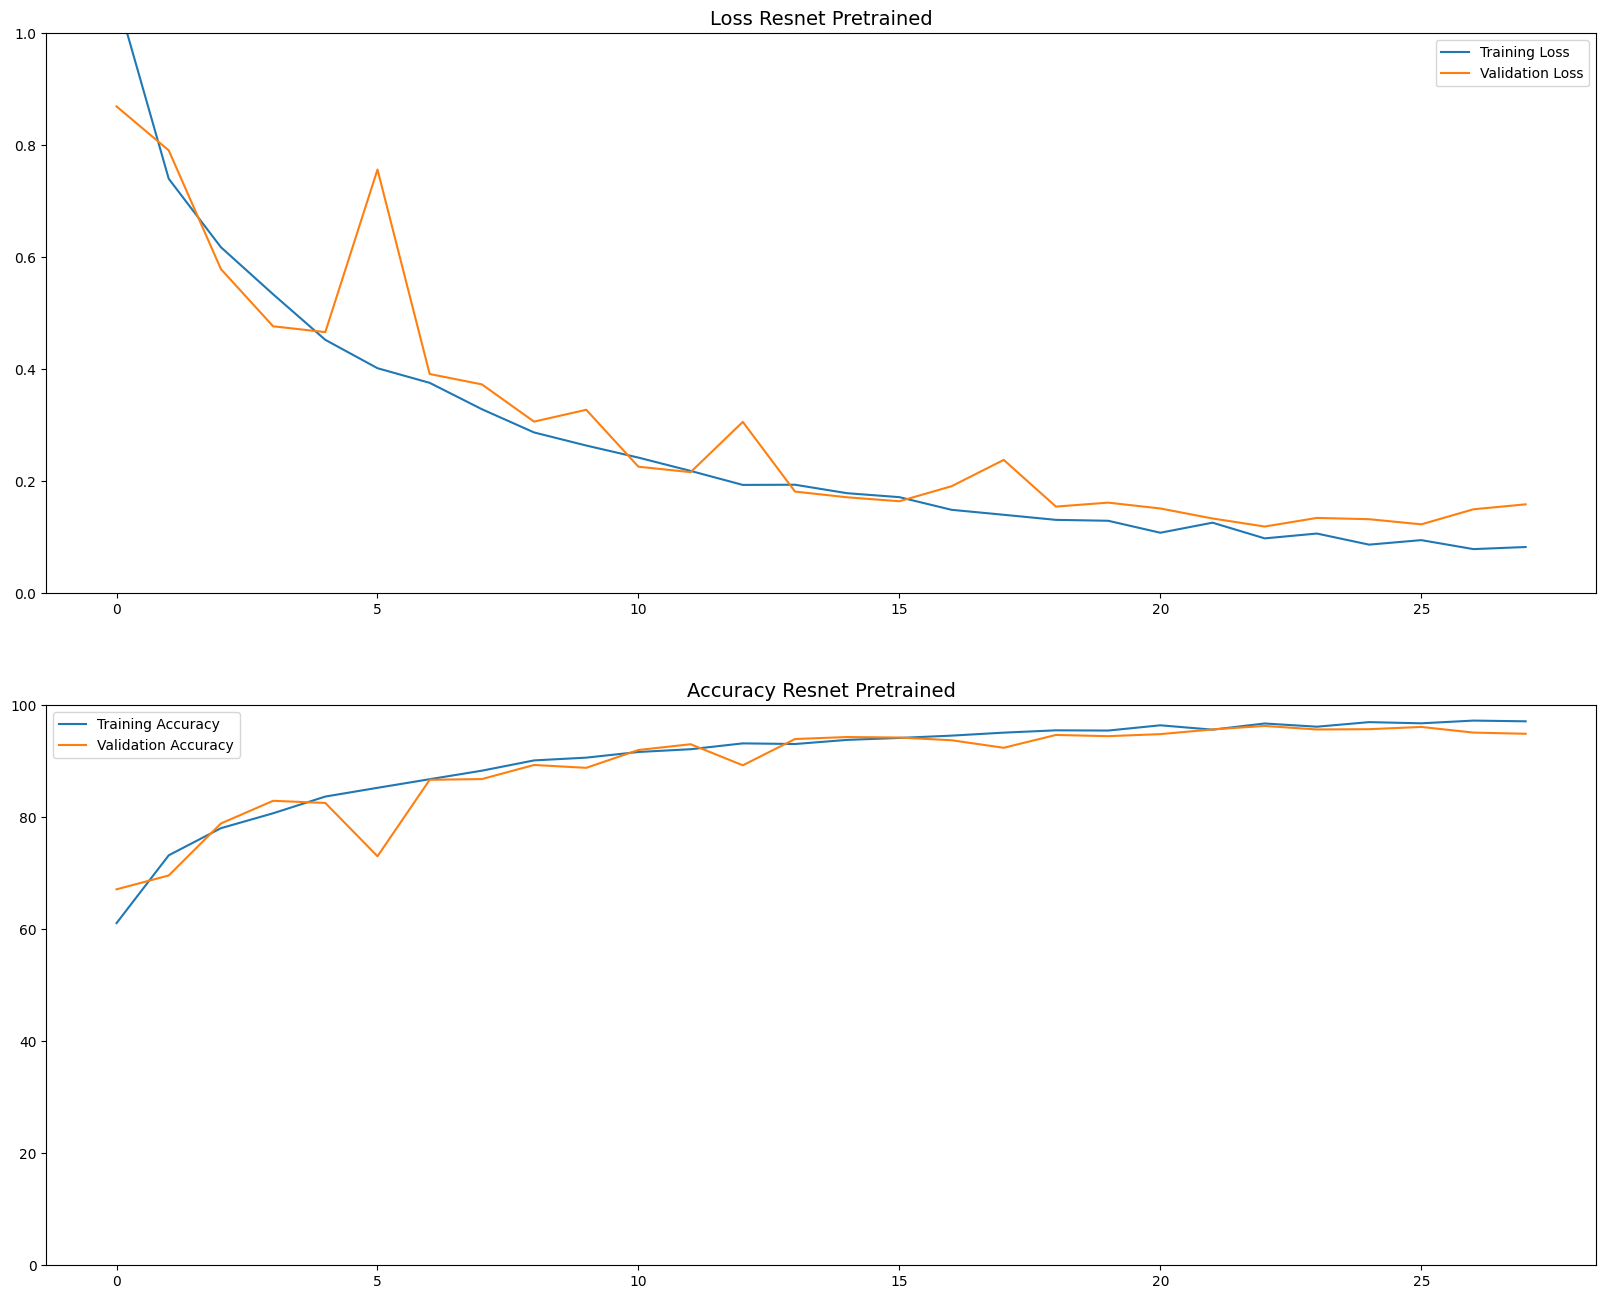

In [65]:
fig = plt.figure(num=2, figsize=(20, 16))  
fig1 = fig.add_subplot(2, 1, 1)
fig2 = fig.add_subplot(2, 1, 2)

fig1.plot(total_loss_train, label='Training Loss')
fig1.plot(total_loss_val, label='Validation Loss')
fig1.set_title('Loss Resnet Pretrained', fontsize=14)  
fig1.set_ylim([0, 1])
fig1.legend()
fig2.plot(total_acc_train, label='Training Accuracy')
fig2.plot(total_acc_val, label='Validation Accuracy')
fig2.set_ylim([0, 100])
fig2.set_title('Accuracy Resnet Pretrained', fontsize=14)  
fig2.legend()
plt.show()

In [2]:
best_model_state = torch.load('resnet_pret.pth', map_location='cpu', weights_only=False)
model_res.load_state_dict(best_model_state)
model_res.to('cpu')  
device = torch.device('cpu')
test_accuracy = test_model(model_res, test_loader, device)

print('-------------------------------------------------------')
print(f'Best model\'s accuracy: {test_accuracy}')
print('-------------------------------------------------------')

NameError: name 'model_res' is not defined

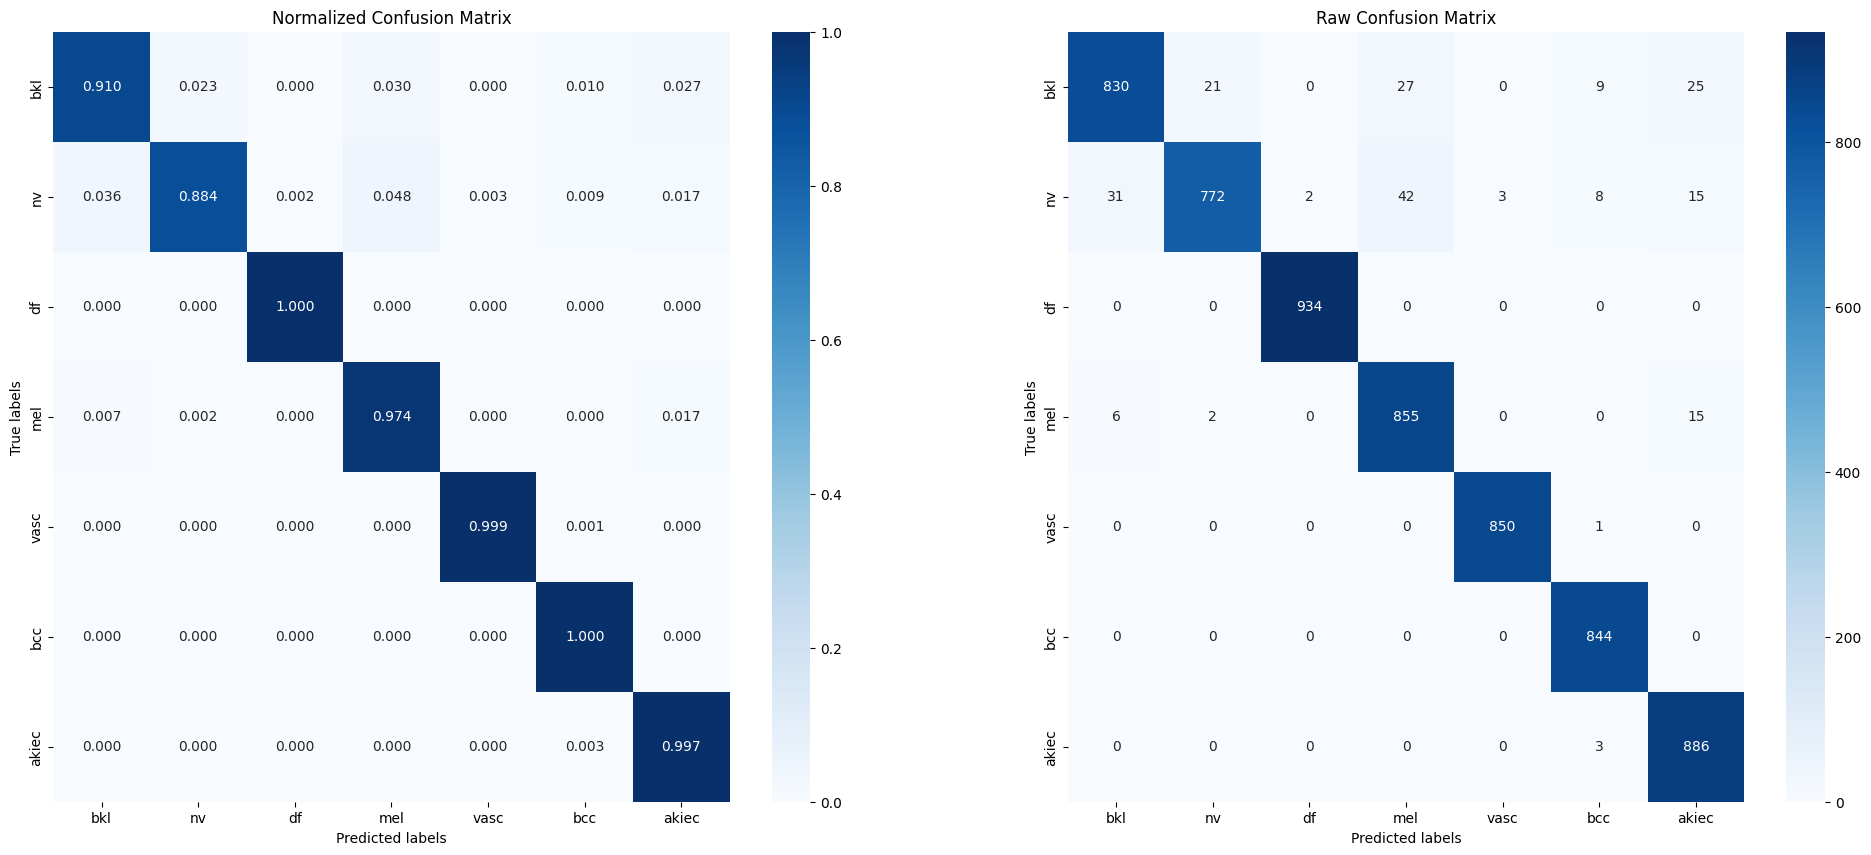

-------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

         bkl       0.96      0.91      0.93       912
          nv       0.97      0.88      0.93       873
          df       1.00      1.00      1.00       934
         mel       0.93      0.97      0.95       878
        vasc       1.00      1.00      1.00       851
         bcc       0.98      1.00      0.99       844
       akiec       0.94      1.00      0.97       889

    accuracy                           0.97      6181
   macro avg       0.97      0.97      0.97      6181
weighted avg       0.97      0.97      0.97      6181

-------------------------------------------------------


In [67]:
conf_report(model_res, test_loader, 'resnet_conf_mat')